In [1]:
%load_ext autoreload

# Probabilistic Principal Component Analysis

In [2]:
import os
import time
import torch
import numpy as np

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from regilib.core.dynamics.dynamical_state import DynamicalState

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class PPCAModel(GenerativeModel):
    def __init__(self, n_components):
        self.n=n_components
        self.pca = PCA(n_components=self.n, svd_solver='full', whiten=True)

    @property
    def n_components(self):
        return self.pca.n_components_

    def fit_model(self, X, path):
        start_time = time.time()
        self.pca.fit(X)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def encode(self, X):
        # based on https://tvml.github.io/ml1718/slides/probabilistic_pca.pdf
        _X = (X - self.pca.mean_).numpy()
        W = self.pca.components_ * np.sqrt(
            self.pca.explained_variance_[:, np.newaxis])
        sigma2 = self.pca.noise_variance_

        M = W @ W.T + sigma2*np.eye(self.pca.n_components_)
        z = _X @ (W.T @ np.linalg.inv(M).T)

        return torch.from_numpy(z)

    def decode(self, X):
        return torch.from_numpy(self.pca.inverse_transform(X))

    def save(self, path):
        dump(self, os.path.join(path, 'model.joblib')) 
    
    def load(path):
        return load(os.path.join(path, 'model.joblib'))
    
    def save_exists(path):
        return os.path.isfile(os.path.join(path, 'model.joblib'))
        
    def log_likelihood(self, X):
        return torch.from_numpy(self.pca.score_samples(X))

    def sample_posterior(self, n_samples, include_noise=False):
        z_samples = np.random.normal(0, 1, [n_samples, self.pca.n_components_])

        if include_noise:
            # x ∼ N(W^Tz, σI)
            # TODO: do this more efficiently
            samples = np.concatenate(
                [np.random.multivariate_normal(
                    self.pca.inverse_transform(z),
                    self.pca.noise_variance_ * np.eye(self.pca.n_features_) , 1)
                for z in z_samples]
            )
        else:
            # x = W^Tz
            samples = self.pca.inverse_transform(z_samples)


        return torch.from_numpy(samples)

    def __str__(self):
        return 'ppca_{}_components'.format(self.n)

## Experiment 1a: swiss roll (2-components)

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/ppca_2_components'

if store_results:
    result_save_path = '../results/swiss_roll/ppca_2_components'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('pythreejs')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and PPCAModel.save_exists(model_save_path):
    model = PPCAModel.load(model_save_path)
else:
    model = PPCAModel(n_components=2)
    model.fit_model(dataset.X, result_save_path)
    
    if store_results:
        model.save(model_save_path)

### Input Representation

In [8]:
from pdmtut.vis import plot_representation

In [9]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]]])

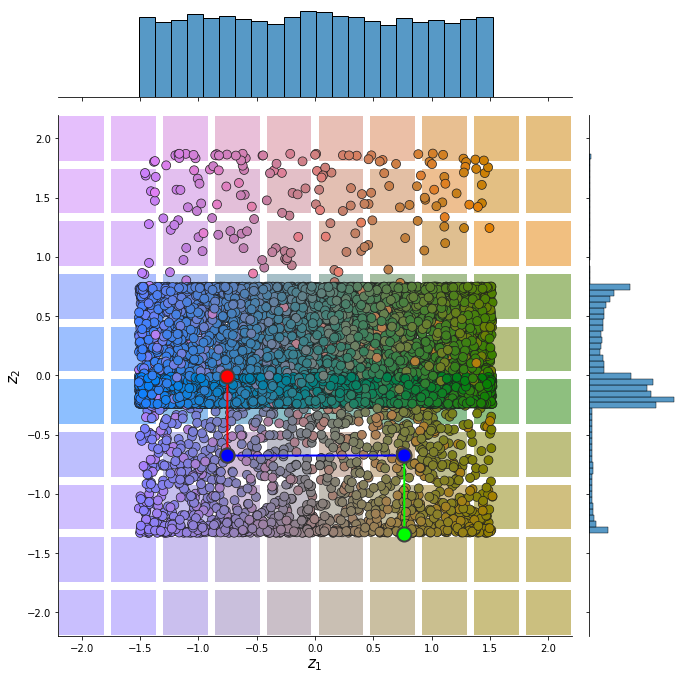

In [10]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [11]:
from pdmtut.vis import plot_reconstruction

In [12]:
z = model.encode(dataset.X)
x = model.decode(z)

In [13]:
mse = (dataset.unnormalise_scale(dataset.X) - dataset.unnormalise_scale(x)).pow(2).sum(-1).mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'reconstruction.txt'), 'w') as f:
        f.write(str(mse.item()))
        
mse

tensor(10.4222, dtype=torch.float64)

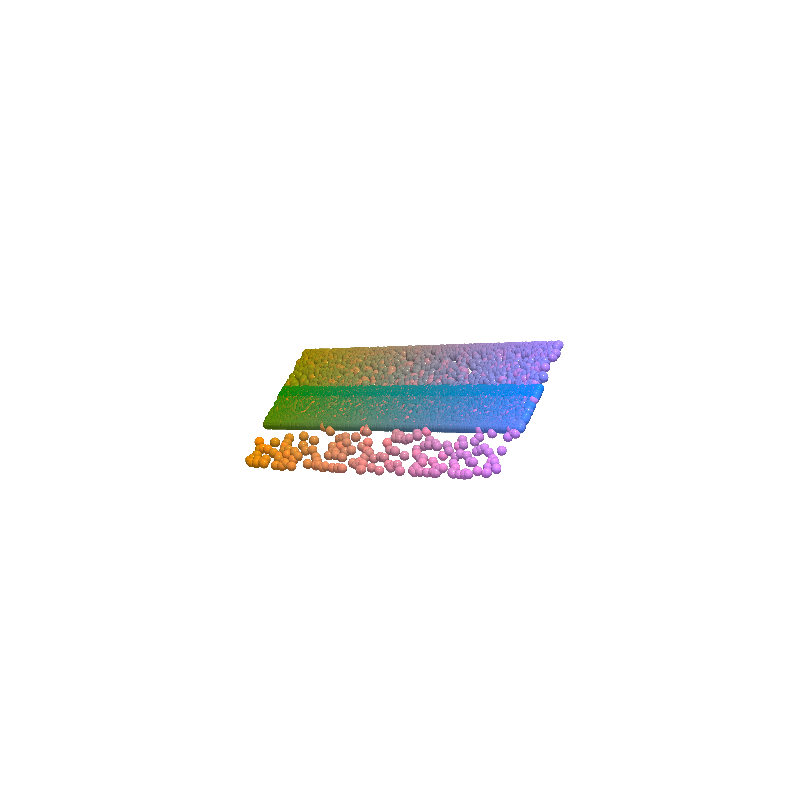

In [14]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [15]:
from pdmtut.vis import plot_density
from regilib.core.invertible_modules.bijective import AffineTransform

In [16]:
log_likelihood = model.log_likelihood(dataset.X)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=dataset.X.clone().requires_grad_(True), log_prob=log_likelihood.clone()))

In [17]:
data_log_likelihood = data.log_prob.mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'density.txt'), 'w') as f:
        f.write(str(data_log_likelihood.item()))
        
data_log_likelihood

tensor(-8.5386, dtype=torch.float64)

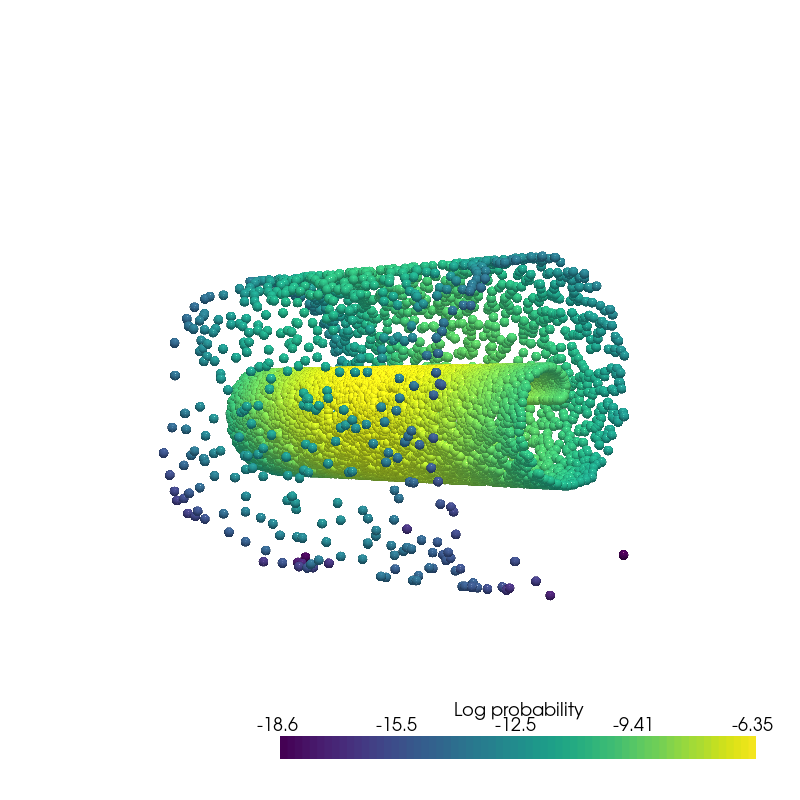

In [18]:
plot_density(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Generate Samples

In [19]:
from pdmtut.vis import plot_generated_samples
from regilib.core.invertible_modules.bijective import AffineTransform

In [20]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=generated_samples.clone().requires_grad_(True), log_prob=generated_samples_log_likelihood.clone()))

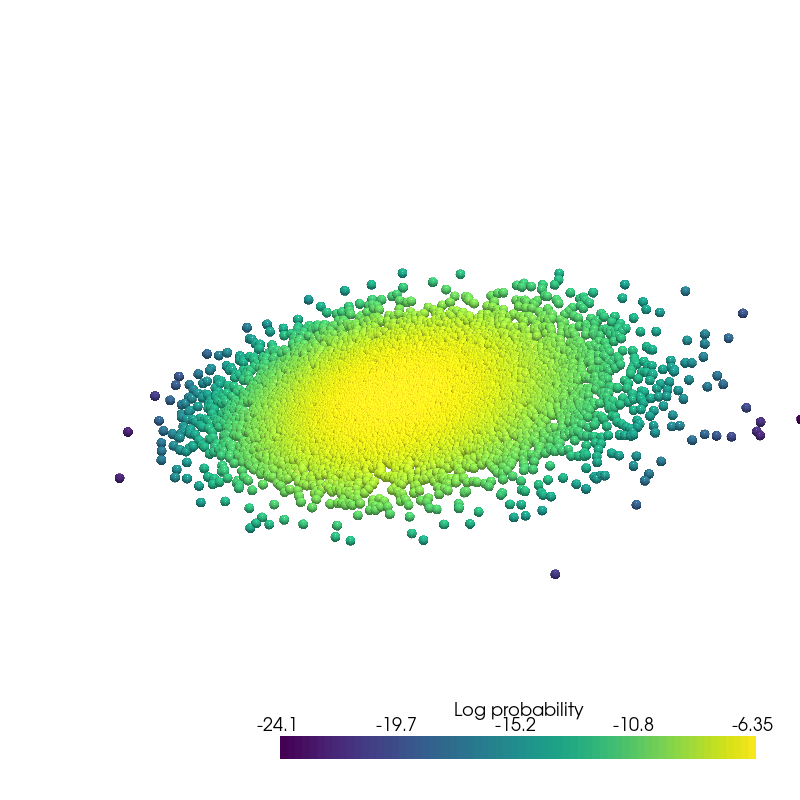

In [21]:
plot_generated_samples(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Interpolation

In [22]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [23]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3 = model.decode(torch.Tensor(linfit3(np.arange(1,21))))

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


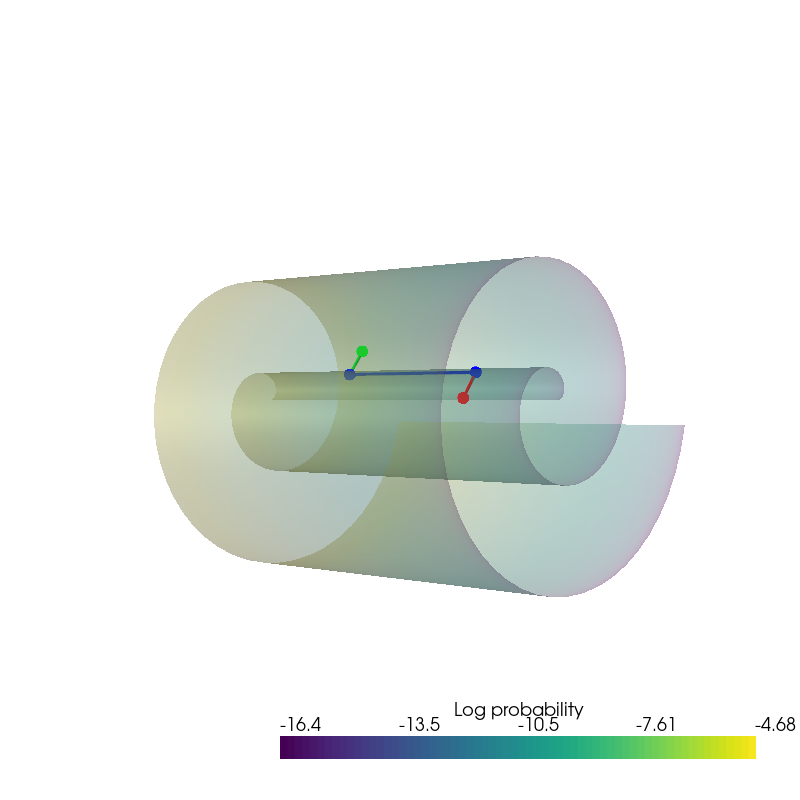

In [24]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    dataset.unnormalise_scale(interpolated_points_3).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)

## Experiment 1b: swiss roll (3-components)

In [25]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/ppca_3_components'

if store_results:
    result_save_path = '../results/swiss_roll/ppca_3_components'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None 

In [26]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and PPCAModel.save_exists(model_save_path):
    model = PPCAModel.load(model_save_path)
else:
    model = PPCAModel(n_components=3)
    model.fit_model(dataset.X, result_save_path)
    
    if store_results:
        model.save(model_save_path)

In [27]:
from pdmtut.vis import plot_representation

In [28]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)
z_extremes = torch.cat([z_extremes, z_extremes[[1,2]]])

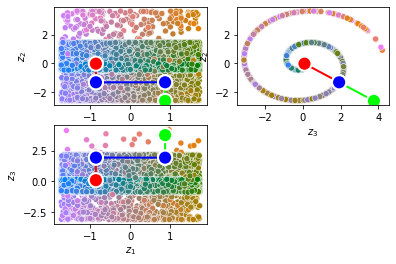

In [29]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [30]:
from pdmtut.vis import plot_reconstruction

In [31]:
z = model.encode(dataset.X)
x = model.decode(z)

In [32]:
mse = (dataset.unnormalise_scale(dataset.X) - dataset.unnormalise_scale(x)).pow(2).sum(-1).mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'reconstruction.txt'), 'w') as f:
        f.write(str(mse.item()))
        
mse

tensor(5.9800e-14, dtype=torch.float64)

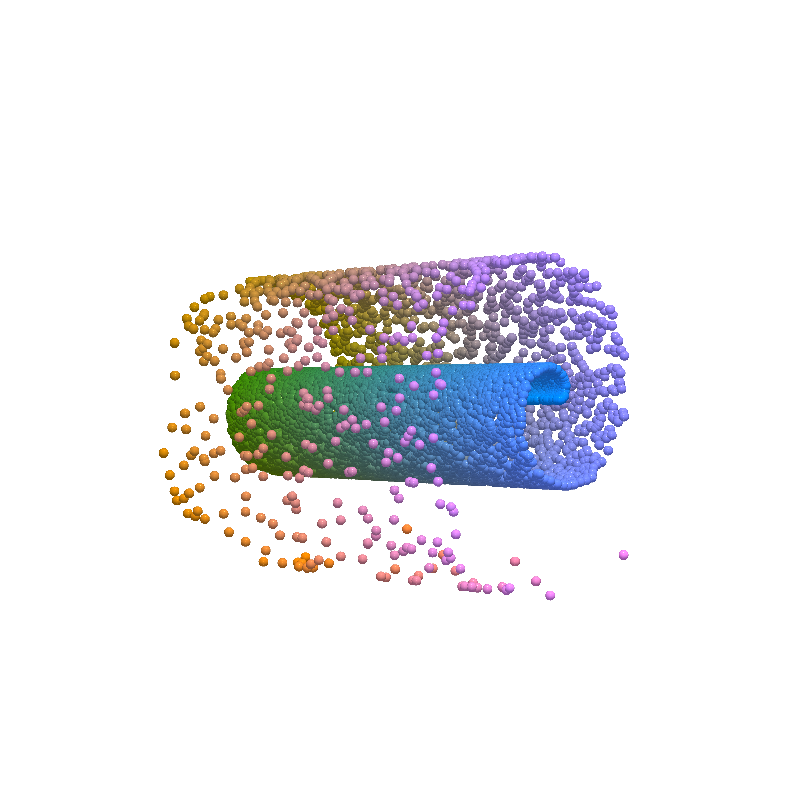

In [33]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [34]:
from pdmtut.vis import plot_density
from regilib.core.invertible_modules.bijective import AffineTransform

In [35]:
log_likelihood = model.log_likelihood(dataset.X)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=dataset.X.clone().requires_grad_(True), log_prob=log_likelihood.clone()))

In [36]:
data_log_likelihood = data.log_prob.mean()

if result_save_path is not None: 
    with open(os.path.join(result_save_path, 'density.txt'), 'w') as f:
        f.write(str(data_log_likelihood.item()))
        
data_log_likelihood

tensor(-25.1159, dtype=torch.float64)

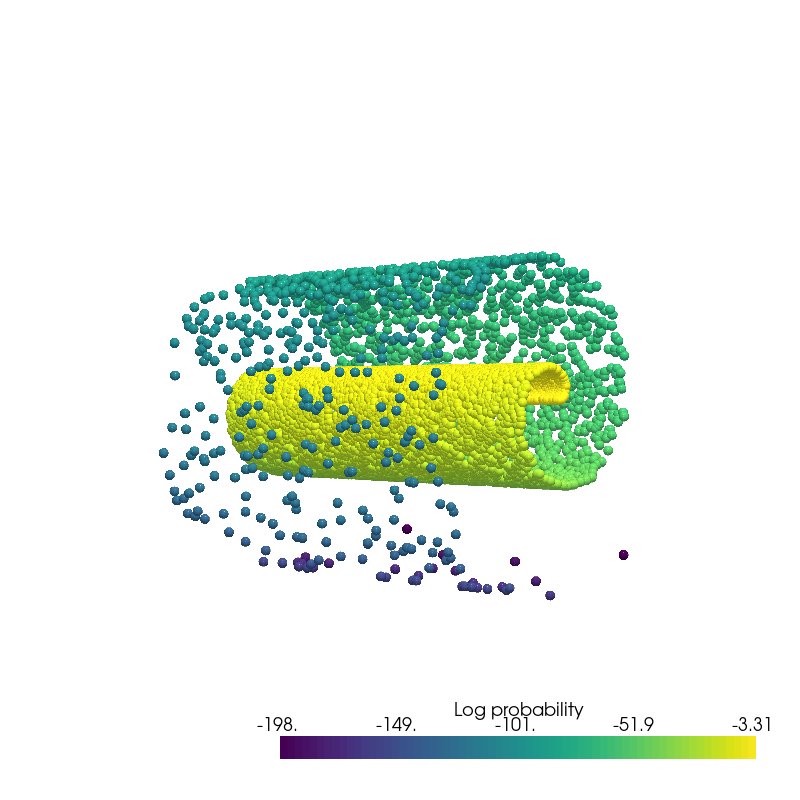

In [37]:
plot_density(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Generate Samples

In [38]:
from pdmtut.vis import plot_generated_samples
from regilib.core.invertible_modules.bijective import AffineTransform

In [39]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

# unnormalise the data and compute the change in density
un_normalise = AffineTransform(dataset._mean, 1/dataset._std)
data = un_normalise.forward(DynamicalState(state=generated_samples.clone().requires_grad_(True), log_prob=generated_samples_log_likelihood.clone()))

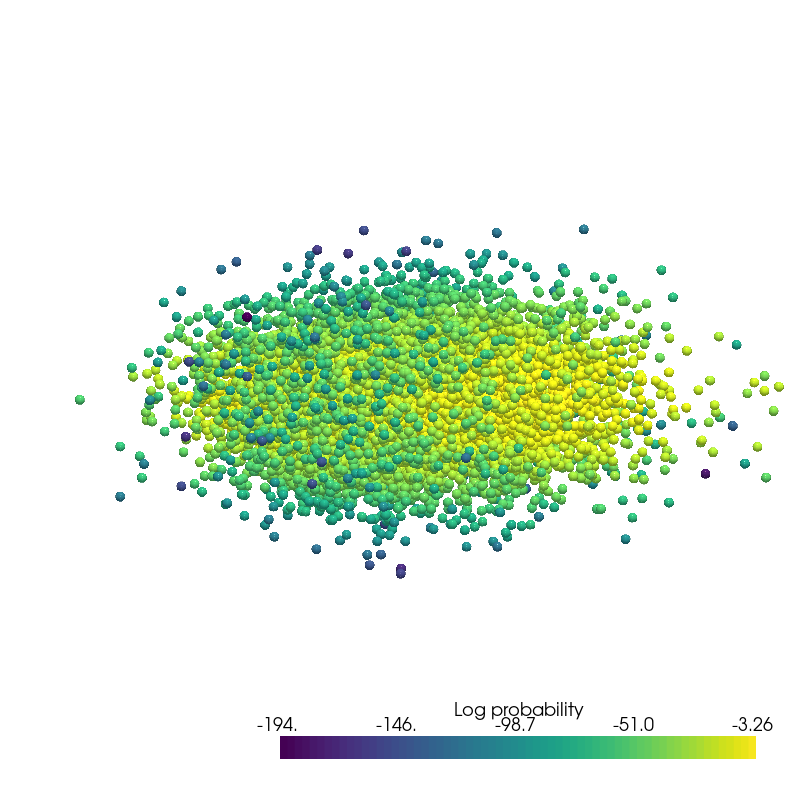

In [40]:
plot_generated_samples(data.state.detach().numpy(), data.log_prob.detach().numpy(), root=result_save_path)

### Interpolation

In [41]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [42]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)
linfit3 = interp1d([1,20], z_extremes[[1,2]].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))
interpolated_points_3 = model.decode(torch.Tensor(linfit3(np.arange(1,21))))

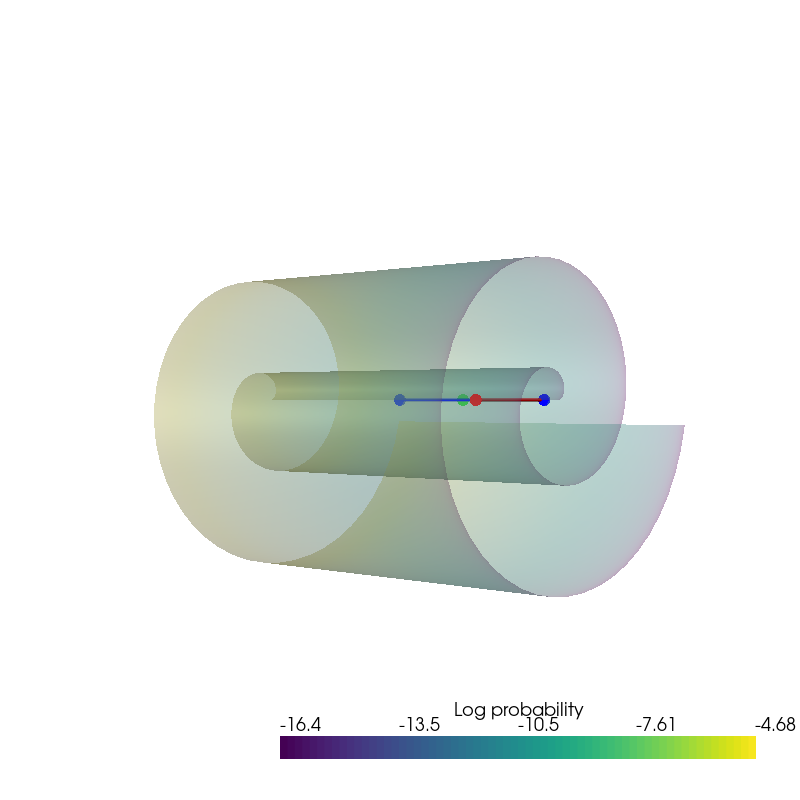

In [43]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    dataset.unnormalise_scale(interpolated_points_3).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)